# <center>Predict rain based on other weather variables</center>

This notebook will use time lags to train a machine learning model for predicting temprature. 

First, we select a random station. The data is kept at daily resolution. Then, we generate a lagged feature matrix.

In [1]:
import pandas as pd
import numpy as np
from numpy.random import randint
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression,Lasso,LassoCV,LassoLarsCV,RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import glob
from mpl_toolkits.basemap import Basemap
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
%%html
<style>
table td, table th, table tr {text-align:center !important;}
</style>

## 1. Data Preparing

### 1.1 Data Loading

In [3]:
data_dir = '/datasets/NOAA_SST/'
#load(data_dir + “noaa_gsod/…/file”
t0 = time.time()
data = pd.read_pickle(data_dir+'noaa_gsod/Combined_noaa_gsod') # load weather data
stations = pd.read_pickle(data_dir+'noaa_gsod.stations') # load station data
"""
Timestamp > 1/1/2008 -> only data in [2008, 2018]
"""
data = data.loc[data.index >= pd.Timestamp(2008, 1, 1)] # days after 1/1/2018
data = data.drop(columns=['yr','year','da','mo']) # don't need these anymore
print("Implementing data loading takes: " + str(time.time()-t0) + " sec")

Implementing data loading takes: 23.978556871414185 sec


> #### ATTRIBUTE MEANING
> |Attribute|Meaning|Type|
    |:-:|:-:|:-:|
    |stn|unique station identifier|string|
    |slp|sea level pressure, station-adjusted|float|
    |wdsp|mean sustained daily wind speed|float|
    |mxpsd|max sustained daily wind speed|float|
    |max|maximum daily temperature|float|
    |min|minimum daily temperature|float|
    |prcp|mean daily precipitation (snow, rain, sleet, etc.)|float|
>
>To see the meaning of more attributes, please refer to [the website](https://data.noaa.gov/dataset/dataset/global-surface-summary-of-the-day-gsod/)

### 1.2. Select Random Station

In [68]:
'''
rs = np.unique(data['stn'].values) # find unique stations with data
rand_stat = rs[randint(len(rs))] # pick a random station

"""
Ideally we should check < len(np.unique(data.index)), but many are shorter
"""

while (len(data.loc[data['stn'] == rand_stat]) < 3650): # If not enough data
    if len(stations.loc[stations['usaf'] == rand_stat]): # If station info available
        if (stations.loc[stations['usaf'] == rand_stat].iloc[0]['wban'] != '99999'): # If station number not unique
            rand_stat = rs[randint(len(rs))] # get a new station
    else:
        rand_stat = rs[randint(len(rs))] # get a new station
'''
import pickle
with open ("station","rb") as f:
    rand_stat = pickle.load(f)
select_station = stations.loc[stations['usaf'] == rand_stat] # get location, etc, for random station


In [69]:
select_station.head()

,usaf,wban,name,country,state,call,lat,lon,elev,begin,end
23130,591340,99999,GAOQI,CH,None,ZSAM,24.544,118.128,+0018.0,19560820,20190401


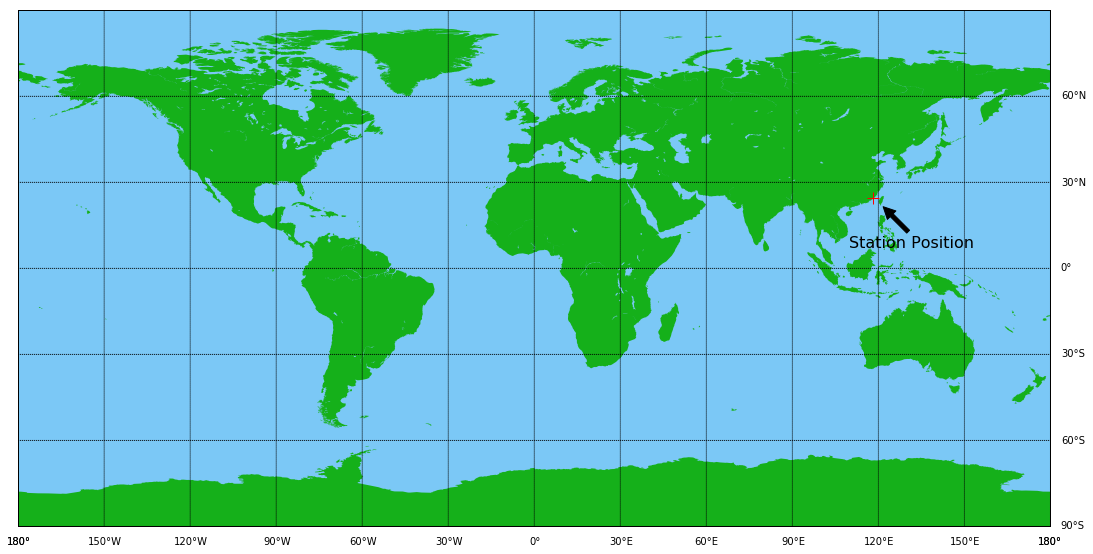

In [12]:
fig = plt.figure(figsize=(18.5, 10.5))
m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180, resolution='l')
m.drawmapboundary(fill_color='xkcd:lightblue')
m.fillcontinents(color='xkcd:green',lake_color='xkcd:lightblue')
m.drawmeridians(np.arange(-180.,180.,30.),labels=[True,False,False,True])
m.drawparallels(np.arange(-90.,90,30.),labels=[False,True,True,False])
lon = select_station['lon'].tolist()
lat = select_station['lat'].tolist()

"""
Station Position: 
    : marker: red "+"
    : annotation: black arrow
"""
m.plot(lon, lat, 'r+', markersize = 12) 
plt.annotate(r'Station Position', xy=(lon[0]+3, lat[0]-2.5), xycoords='data', xytext=(+30, -30),
             textcoords='offset points', fontsize=16,arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='center',verticalalignment='top')
plt.show()

### 1.3 DataFrames for different weather attributes

In [70]:
def get_data_frame(weather):
    assert isinstance(weather,list)
    DF = {} # dataframe dict
    features = data.loc[data['stn'] == rand_stat]
    features = features.drop(columns = "stn")
    for i in range(4):
        outlier1 = np.argwhere(features['wdsp'] == np.max(features['wdsp']))
        features = features.drop(features.index[outlier1[0][0]])
    for i in range(10):
        outlier1 = np.argwhere(features['prcp'] == np.max(features['prcp']))
        features = features.drop(features.index[outlier1[0][0]])    
    for i in range(2):
        outlier1 = np.argwhere(features['slp'] == np.min(features['slp']))
        features = features.drop(features.index[outlier1[0][0]])
        outlier1 = np.argwhere(features['slp'] == np.max(features['slp']))
        features = features.drop(features.index[outlier1[0][0]])
    for w in weather:
        if w == "temp":
            df = features.drop(columns = ["max", "min"])
        elif w == "wdsp":
            df = features.drop(columns = "mxpsd")
        elif w == "prcp": 
            df = features
        else:
            df = features
        df = df.sort_index()
        DF[w] = df
    return DF

In [71]:
DF = get_data_frame(["temp", "wdsp", "prcp","slp"])

### 1.4. Time-shift the data

In [72]:
for weather in DF:
    columns = DF[weather].columns 
    for co in columns:
        DF[weather][co + '_lag1'] = DF[weather][co].shift(periods=1)
        DF[weather][co + '_lag2'] = DF[weather][co].shift(periods=2)
        DF[weather][co + '_lag3'] = DF[weather][co].shift(periods=3)       
    DF[weather] = DF[weather].iloc[3:]
    print(weather + ": " + str(DF[weather].shape[0]) + ' samples, ' + str(DF[weather].shape[1]) + ' features.')
    DF[weather].head()

temp: 3984 samples, 20 features.
wdsp: 3984 samples, 24 features.
prcp: 3984 samples, 28 features.
slp: 3984 samples, 28 features.


In [ ]:
import seaborn as sns
sns.pairplot(DF["weather",vars=['DMC','temp','RH','rain'],kind='reg',hue='FIRE',palette='hls',markers=["o", "x"]) 
# hue='FIRE',to classify the data by variable 'FIRE' ; kind='reg', to introduce linear regression 
plt.show()


### 1.6. Create training /validation /test set

In [73]:
"""
1. ylabel setting - temperature
drop it from original data
"""

data_set = {}

for weather in DF:
    df = DF[weather]
    ylabel = df[weather] # use today's temperature as the label
    DF[weather] = DF[weather].drop(columns = weather) # don't put it in training data!!
    df = df.drop(columns = weather) # don't put it in training data!!
    ntrain = int(df.shape[0] * 0.8)
    x_test = df.iloc[ntrain:,:]
    y_test = ylabel[ntrain:]
    indices = np.arange(ntrain)
    x_train, x_val, y_train, y_val = train_test_split(df.iloc[:ntrain,:], 
                                                  ylabel[:ntrain],
                                                  train_size = 0.8, 
                                                  test_size = 0.2, 
                                                  random_state = 1)
    scaler = MinMaxScaler() #scale features between 0 and 1
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)
    x_test = scaler.transform(x_test)
    data_set[weather] = [x_train,y_train,x_test,y_test,x_val,y_val,ylabel]

## 2. Find the best candidate ML model

In [33]:
model = RandomForestRegressor(n_jobs = -1)
x_train, y_train, x_test, y_test, x_val, y_val,_ = data_set["prcp"]
model.fit(x_train, y_train)
print("\n RandomForestRegressor metrics:")
print("\tCross validated R^2 of {:.4}".format(model.score(x_val, y_val)))

y_pred = model.predict(x_val)
print("\tRMSE of {:.4}".format(str(mean_squared_error(y_val, y_pred))))
print("\tMAE of {:.4} \n".format(str(mean_absolute_error(y_val, y_pred))))

print("Scores of test set: %s" %model.score(x_test, y_test))
print("Scores of training set: %s" %model.score(x_train, y_train))

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



 RandomForestRegressor metrics:
	Cross validated R^2 of 0.1075
	RMSE of 0.15
	MAE of 0.18 

Scores of test set: 0.13744992183767213
Scores of training set: 0.8249146771792435


In [19]:
color = {"temp":[["lightcoral", "deepskyblue"], ["skyblue","slateblue"]],
         "wdsp":[["lightsteelblue", "violet"], ["darkseagreen", "sandybrown"]],
         "prcp":[["gray", "goldenrod"], ["rosybrown", "cadetblue"]],
         "slp":[["r","blue"],["yellow","green"]]}
x_space = [30, 60]
title = ["Test Set", "Training Set"]

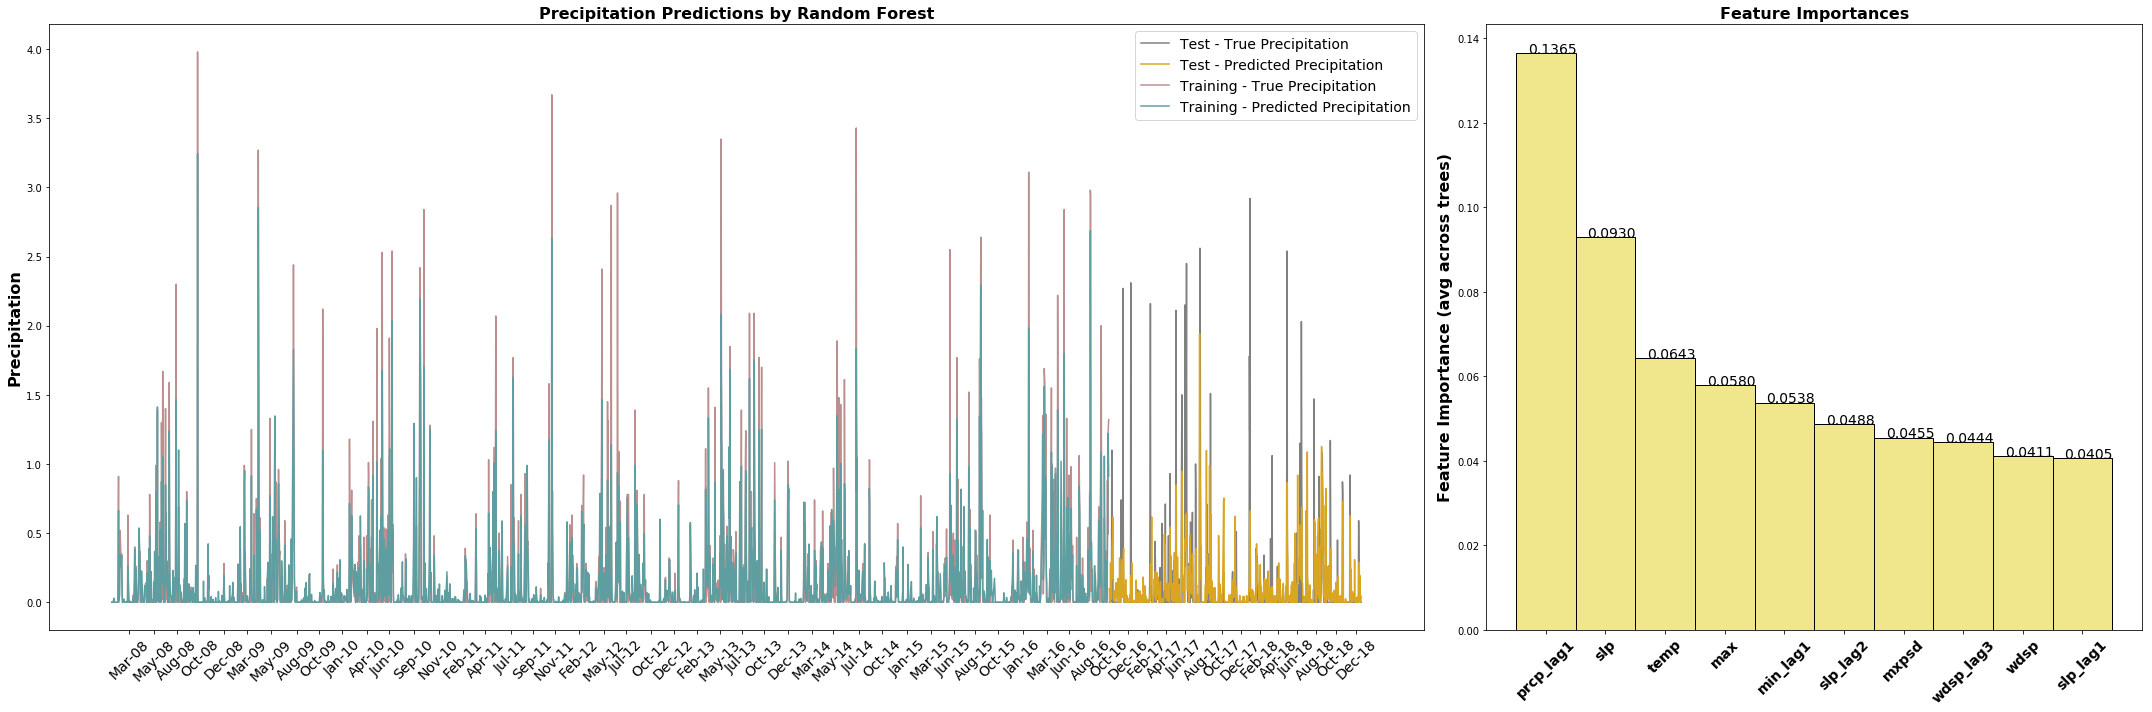

In [35]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(30,10))
gs = GridSpec(10, 30)
for weather in ["prcp"]:
    x_train, y_train, x_test, y_test, x_val, y_val,_ = data_set[weather]
    Y_train = model.predict(x_train)
    Y_test = model.predict(x_test)
    # sort the indcies
    order = y_train.index.argsort()
    sorted_yt = y_train[order]
    sorted_yp = Y_train[order]
    x_axis = [DF[weather].iloc[ntrain:].index, sorted_yt.index]
    y_axis = [[y_test, Y_test], [sorted_yt, sorted_yp]]
    
    plt.subplot(gs[:,:20])
    p1, = plt.plot(x_axis[0], y_axis[0][0], color[weather][0][0] ) # plot actual temperature
    p2, = plt.plot(x_axis[0], y_axis[0][1], color[weather][0][1]) # plot predicted temperature
    p3, = plt.plot(x_axis[1], y_axis[1][0], color[weather][1][0] ) # plot actual temperature
    p4, = plt.plot(x_axis[1], y_axis[1][1], color[weather][1][1] ) # plot actual temperature
        
    combined_x = [i for j in range(2) for i in x_axis[j]]
    plt.xticks(combined_x[::60], rotation = 45, fontsize = 14) # set xticks to monthly
    myFmt = mdates.DateFormatter("%b-%y") # This shows day-month-year. Switch to month-year or annually
    plt.gca().xaxis.set_major_formatter(myFmt)

    plt.title("Precipitation Predictions by Random Forest",fontsize = 16,weight = "bold")
    plt.ylabel('Precipitation', fontsize = 16,weight = "bold")
    plt.legend([p1,p2,p3,p4],['Test - True Precipitation',
                              'Test - Predicted Precipitation',
                              'Training - True Precipitation',
                              'Training - Predicted Precipitation'], fontsize = 14, loc = 1) 
    
    clf = model
    features = DF["prcp"]
    nfeatures = 10
    fi = clf.feature_importances_ 
    sorted_ind = np.argsort(fi)[::-1][:nfeatures] 

    plt.subplot(gs[:,20:])
    plt.bar(range(nfeatures), fi[sorted_ind], width=1,
            tick_label = features.columns.values[sorted_ind],
           color = "khaki", edgecolor = "black", linewidth = 1) # plot features importances
    """
    Feature value Annotation
    """
    for i in range(nfeatures):
        if i == 0:
            plt.text(i-0.3, fi[sorted_ind][i], "{0:.4f}".format(fi[sorted_ind][i]), fontsize = 14)
        else:
            plt.text(i-0.3, fi[sorted_ind][i], "{0:.4f}".format(fi[sorted_ind][i]), fontsize = 14, rotation = 0)


    plt.title("Feature Importances", fontsize=16, weight = "bold")
    plt.ylabel("Feature Importance (avg across trees)", fontsize=16, weight = "bold")
    plt.xticks(rotation = 45, fontsize = 14, weight = "bold")
    #fig.suptitle("Precipitation", weight = "bold", fontsize = 18)
    plt.tight_layout()
    plt.show()

> ### MODEL
1. **RandomForestRegressor**
2. **Hyperparamter Tuning**: GridSearchCV

### 2.1 Utilize GridSearch for hyperparameter tuning to find the best parameters

In [36]:
def candidate_models():
    """
    Build candidate ML models for prediction
    """
    models = {}
    models['Linear Regression'] = LinearRegression(n_jobs = -1)
    models['LassoCV'] = LassoCV(n_jobs = -1)
    models['LassoLarsCV'] = LassoLarsCV(n_jobs = -1)
    models['SVR'] = GridSearchCV(SVR(), cv = 5,
                                        param_grid = {"kernel": ["linear", "poly", "rbf"],
                                                        "gamma":["scale","auto"]})
    
    models['Decision Tree'] = GridSearchCV(DecisionTreeRegressor(), 
                                           cv = 5,
                                           param_grid = {"max_depth": [2, 20]})
    
    models['Random Forest'] = GridSearchCV(RandomForestRegressor(n_jobs = -1), 
                                           cv = 5,
                                           param_grid = {"max_depth": [2, 20]})
                                           
    models['Ada Boost'] = GridSearchCV(AdaBoostRegressor(), 
                                       cv=5,
                                       #param_grid={"loss": ['linear', 'square'], 
                                       param_grid={"learning_rate": [0.05, 0.1]})
    models['Gradient Boost'] = GridSearchCV(GradientBoostingRegressor(), 
                                            cv=5, 
                                            #param_grid={"max_depth": [4, 5], 
                                             param_grid={"learning_rate": [1e-5, 1e-4, 1e-3]})
    return models

In [37]:
def fit_n_score(model, x_train, x_val,x_test, y_train, y_val,y_test, model_name):
    model.fit(x_train, y_train)
    model.fit(x_train, y_train)
    print("\n {0} metrics:".format(model_name))
    print("\tCross validated R^2 of {:.4}".format(model.score(x_val, y_val)))

    y_pred = model.predict(x_val)
    print("\tRMSE of {:.4}".format(str(mean_squared_error(y_val, y_pred))))
    print("\tMAE of {:.4} \n".format(str(mean_absolute_error(y_val, y_pred))))
    try:
        print("Best estimator of Random Forest:\n %s" %model.best_estimator_,"\n")
    except:
        pass
    print("Scores of training set: %s" %model.score(x_train, y_train))
    print("Scores of validation set: %s" %model.score(x_val, y_val))
    print("Scores of test set: %s" %model.score(x_test, y_test))
    
    try:
        return model.best_estimator_ 
    except:
        return model

In [38]:
def identify_best_model(weather):
    """
    Score the ML models, return best candidate ML model.
    """
    #best_model = {}
    x_train, y_train, x_test, y_test, x_val, y_val,_ = data_set[weather]
    models = candidate_models()
    
    best_score = -1
    best_model_name = None
    
    for name, model in models.items():
        print("\n-------- {0} -----------".format(weather))
        model = fit_n_score(model, x_train, x_val,x_test, y_train, y_val,y_test,name)
        cv_score = model.score(x_test, y_test)
        if name == 'Random Forest':
            rf = model
        if cv_score > best_score:
            best_model_name = name
            best_score = cv_score
            best_model = model
    print("Best scoring model: {0} with best score {1}".format(best_model_name,best_score))
    return best_model, rf

In [64]:
Best_model, RF = {}, {}
for weather in DF:
    best_model, rf = identify_best_model(weather)
    Best_model[weather] = best_model
    RF[weather] = rf


-------- temp -----------

 Linear Regression metrics:
	Cross validated R^2 of 0.952
	RMSE of 6.09
	MAE of 1.85 

Scores of training set: 0.9591913808103768
Scores of validation set: 0.9519977741902802
Scores of test set: 0.9568563463283406

-------- temp -----------


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



 LassoCV metrics:
	Cross validated R^2 of 0.9508
	RMSE of 6.24
	MAE of 1.88 

Scores of training set: 0.9586339882050343
Scores of validation set: 0.9507826472187363
Scores of test set: 0.9556895736534591

-------- temp -----------


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



 LassoLarsCV metrics:
	Cross validated R^2 of 0.952
	RMSE of 6.09
	MAE of 1.85 

Scores of training set: 0.9591913808103768
Scores of validation set: 0.9519977741902802
Scores of test set: 0.9568563463283406

-------- temp -----------

 SVR metrics:
	Cross validated R^2 of 0.9438
	RMSE of 7.12
	MAE of 2.03 

Best estimator of Random Forest:
 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 

Scores of training set: 0.9511568380443272
Scores of validation set: 0.9438346539221758
Scores of test set: 0.9483542665704134

-------- temp -----------

 Decision Tree metrics:
	Cross validated R^2 of 0.9072
	RMSE of 11.7
	MAE of 2.56 

Best estimator of Random Forest:
 DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de


 Random Forest metrics:
	Cross validated R^2 of 0.9477
	RMSE of 6.64
	MAE of 1.93 

Best estimator of Random Forest:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False) 

Scores of training set: 0.9909576910303237
Scores of validation set: 0.9476603540114454
Scores of test set: 0.9441202940133064

-------- temp -----------

 Ada Boost metrics:
	Cross validated R^2 of 0.9223
	RMSE of 9.86
	MAE of 2.44 

Best estimator of Random Forest:
 AdaBoostRegressor(base_estimator=None, learning_rate=0.1, loss='linear',
         n_estimators=50, random_state=None) 

Scores of training set: 0.9304869834220367
Scores of validation set: 0.9222837340739798
Scores of test set: 

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of ite


 LassoCV metrics:
	Cross validated R^2 of 0.4217
	RMSE of 3.07
	MAE of 1.37 

Scores of training set: 0.40022691945026856
Scores of validation set: 0.421653063860411
Scores of test set: 0.45430121435040055

-------- wdsp -----------


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



 LassoLarsCV metrics:
	Cross validated R^2 of 0.4213
	RMSE of 3.08
	MAE of 1.37 

Scores of training set: 0.40021231850875416
Scores of validation set: 0.4212894681513518
Scores of test set: 0.4546380817482092

-------- wdsp -----------

 SVR metrics:
	Cross validated R^2 of 0.5389
	RMSE of 2.45
	MAE of 1.19 

Best estimator of Random Forest:
 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 

Scores of training set: 0.5277670611555639
Scores of validation set: 0.5389277804422938
Scores of test set: 0.533541788611368

-------- wdsp -----------

 Decision Tree metrics:
	Cross validated R^2 of 0.1825
	RMSE of 4.35
	MAE of 1.65 

Best estimator of Random Forest:
 DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fr

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de


 Random Forest metrics:
	Cross validated R^2 of 0.392
	RMSE of 3.23
	MAE of 1.40 

Best estimator of Random Forest:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False) 

Scores of training set: 0.8836014148499547
Scores of validation set: 0.3920473449318481
Scores of test set: 0.4408102595323534

-------- wdsp -----------

 Ada Boost metrics:
	Cross validated R^2 of 0.2374
	RMSE of 4.06
	MAE of 1.61 

Best estimator of Random Forest:
 AdaBoostRegressor(base_estimator=None, learning_rate=0.05, loss='linear',
         n_estimators=50, random_state=None) 

Scores of training set: 0.28612304004861555
Scores of validation set: 0.23737950673179373
Scores of test set

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of ite


 LassoCV metrics:
	Cross validated R^2 of 0.2664
	RMSE of 0.14
	MAE of 0.20 

Scores of training set: 0.23580581076646634
Scores of validation set: 0.26635496308194084
Scores of test set: 0.25424910778791143

-------- prcp -----------


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



 LassoLarsCV metrics:
	Cross validated R^2 of 0.2653
	RMSE of 0.14
	MAE of 0.20 

Scores of training set: 0.23414154402615361
Scores of validation set: 0.26526540815313504
Scores of test set: 0.25213088468050804

-------- prcp -----------

 SVR metrics:
	Cross validated R^2 of 0.2026
	RMSE of 0.15
	MAE of 0.17 

Best estimator of Random Forest:
 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 

Scores of training set: 0.2893528609779674
Scores of validation set: 0.20263431659252007
Scores of test set: 0.21349121389699666

-------- prcp -----------

 Decision Tree metrics:
	Cross validated R^2 of 0.04935
	RMSE of 0.18
	MAE of 0.21 

Best estimator of Random Forest:
 DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_wei

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de


 Random Forest metrics:
	Cross validated R^2 of 0.1724
	RMSE of 0.15
	MAE of 0.19 

Best estimator of Random Forest:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False) 

Scores of training set: 0.82419062933817
Scores of validation set: 0.172372709175851
Scores of test set: 0.16066223794970425

-------- prcp -----------

 Ada Boost metrics:
	Cross validated R^2 of 0.1436
	RMSE of 0.16
	MAE of 0.22 

Best estimator of Random Forest:
 AdaBoostRegressor(base_estimator=None, learning_rate=0.05, loss='linear',
         n_estimators=50, random_state=None) 

Scores of training set: 0.265711355506827
Scores of validation set: 0.14359321971356775
Scores of test set: 0

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



 LassoCV metrics:
	Cross validated R^2 of 0.949
	RMSE of 2.57
	MAE of 1.14 

Scores of training set: 0.9469881516698477
Scores of validation set: 0.9490051379710973
Scores of test set: 0.9534561477379879

-------- slp -----------


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)



 LassoLarsCV metrics:
	Cross validated R^2 of 0.9501
	RMSE of 2.52
	MAE of 1.13 

Scores of training set: 0.9475903748147165
Scores of validation set: 0.9500714859162825
Scores of test set: 0.9545603237935805

-------- slp -----------

 SVR metrics:
	Cross validated R^2 of 0.9473
	RMSE of 2.66
	MAE of 1.21 

Best estimator of Random Forest:
 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 

Scores of training set: 0.9480282645718447
Scores of validation set: 0.9472528513405449
Scores of test set: 0.9429601273638578

-------- slp -----------

 Decision Tree metrics:
	Cross validated R^2 of 0.8875
	RMSE of 5.69
	MAE of 1.81 

Best estimator of Random Forest:
 DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fra

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de


 Random Forest metrics:
	Cross validated R^2 of 0.9328
	RMSE of 3.39
	MAE of 1.34 

Best estimator of Random Forest:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False) 

Scores of training set: 0.9883825624850502
Scores of validation set: 0.9327983799724423
Scores of test set: 0.9346687350378319

-------- slp -----------

 Ada Boost metrics:
	Cross validated R^2 of 0.9035
	RMSE of 4.87
	MAE of 1.63 

Best estimator of Random Forest:
 AdaBoostRegressor(base_estimator=None, learning_rate=0.1, loss='linear',
         n_estimators=50, random_state=None) 

Scores of training set: 0.9114708577381043
Scores of validation set: 0.9035343842431236
Scores of test set: 0

### 2.2 Use the best paramters acquired from GridSearch

In [48]:
import pickle
with open("bestmodel","wb") as f:
    pickle.dump(Best_model, f)

### 3. RandomForestPlot

In [122]:
from sklearn.decomposition import PCA

In [243]:
pca1 = PCA(20,whiten = True)
x_train,y_train,x_test,y_test,x_val,y_val,ylabel = data_set["prcp"]
new_d = pca1.fit_transform(x_train-np.mean(x_train,1).reshape(x_train.shape[0],1))
x_tr = np.dot(new_d,new_d.T).dot(x_train)
new_d = pca1.fit_transform(x_val)
x_v = np.dot(new_d,new_d.T).dot(x_val)
new_d = pca1.fit_transform(x_test)
x_te = np.dot(new_d,new_d.T).dot(x_test)

In [250]:
len(rf)

10

In [247]:
model1 = DecisionTreeRegressor(criterion='mse', max_depth=20, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1044483845, splitter='best')
model1.fit(x_tr,y_train)
print("Scores of test set: %s" %model1.score(x_te, y_test))
print("Scores of training set: %s" %model1.score(x_tr, y_train))
print("Scores of validation set: %s" %model1.score(x_v, y_val))

Scores of test set: -0.1407985105828169
Scores of training set: 0.9946537924842103
Scores of validation set: -0.12011141923456803


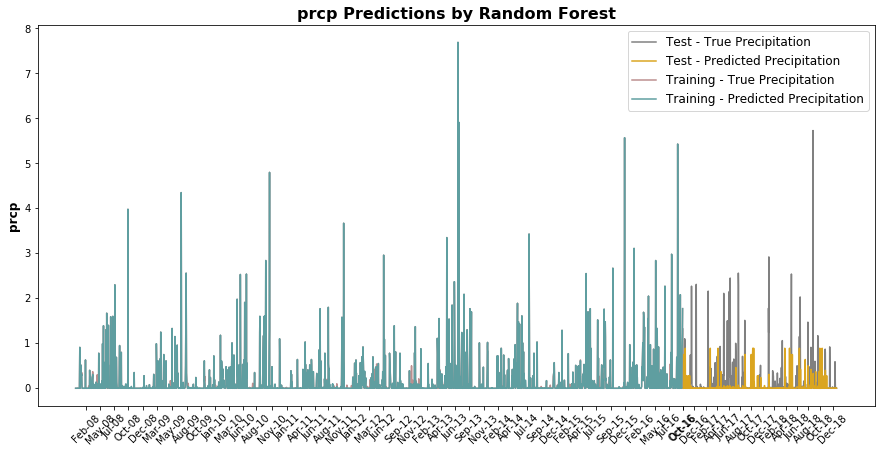

In [248]:
for weather in ["prcp"]:
    Y_train = model1.predict(x_tr)
    Y_test = model1.predict(x_te)
    # sort the indcies
    order = y_train.index.argsort()
    sorted_yt = y_train[order]
    sorted_yp = Y_train[order]
    x_axis = [DF[weather].iloc[ntrain:].index, sorted_yt.index]
    y_axis = [[y_test, Y_test], [sorted_yt, sorted_yp]]
    
    plt.figure(figsize=(15,7))
    p1, = plt.plot(x_axis[0], y_axis[0][0], color[weather][0][0] ) # plot actual temperature
    p2, = plt.plot(x_axis[0], y_axis[0][1], color[weather][0][1]) # plot predicted temperature
    p3, = plt.plot(x_axis[1], y_axis[1][0], color[weather][1][0] ) # plot actual temperature
    p4, = plt.plot(x_axis[1], y_axis[1][1], color[weather][1][1] ) # plot actual temperature
        
    combined_x = [i for j in range(2) for i in x_axis[j]]
    plt.xticks(combined_x[::x_space[1]], rotation = 45) # set xticks to monthly
    myFmt = mdates.DateFormatter("%b-%y") # This shows day-month-year. Switch to month-year or annually
    plt.gca().xaxis.set_major_formatter(myFmt)

    plt.title(weather+" Predictions by Random Forest",fontsize = 16,weight = "bold")
    plt.ylabel(weather, fontsize = 12,weight = "bold")
    plt.legend([p1,p2,p3,p4],['Test - True Precipitation','Test - Predicted Precipitation','Training - True Precipitation','Training - Predicted Precipitation'], fontsize = 12, loc = 1) 



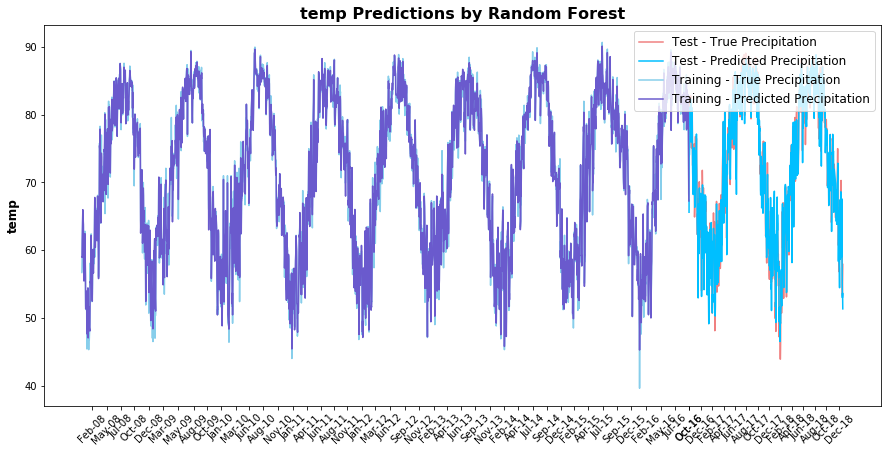

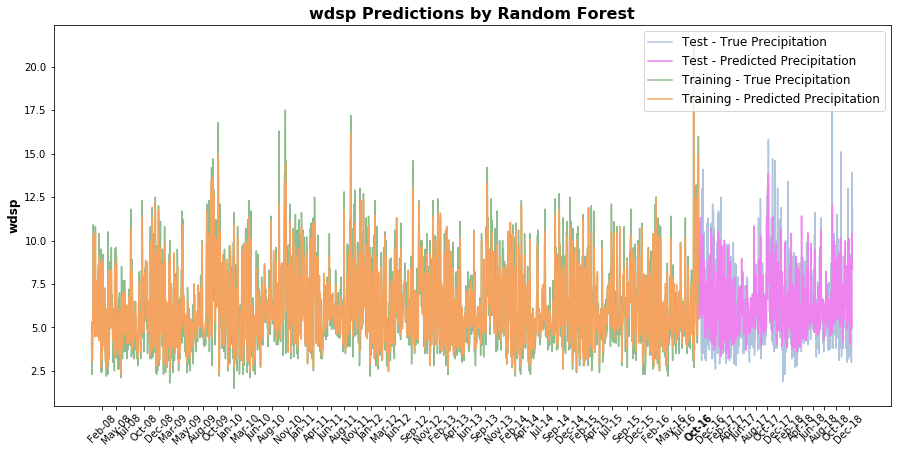

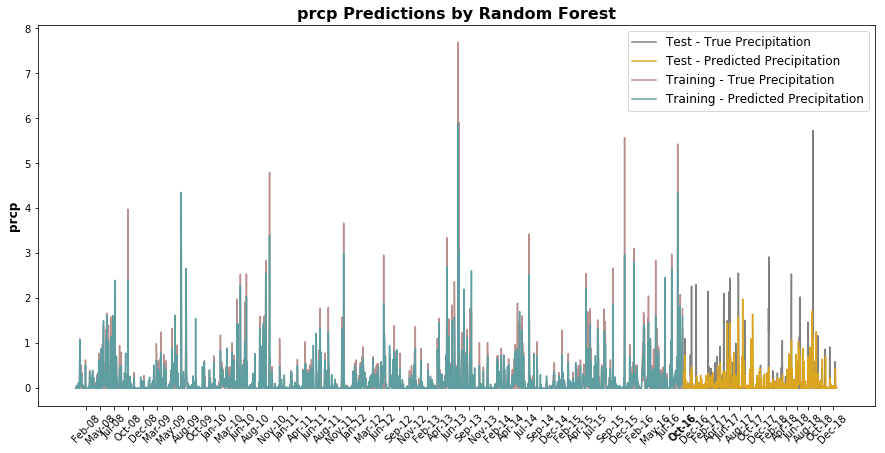

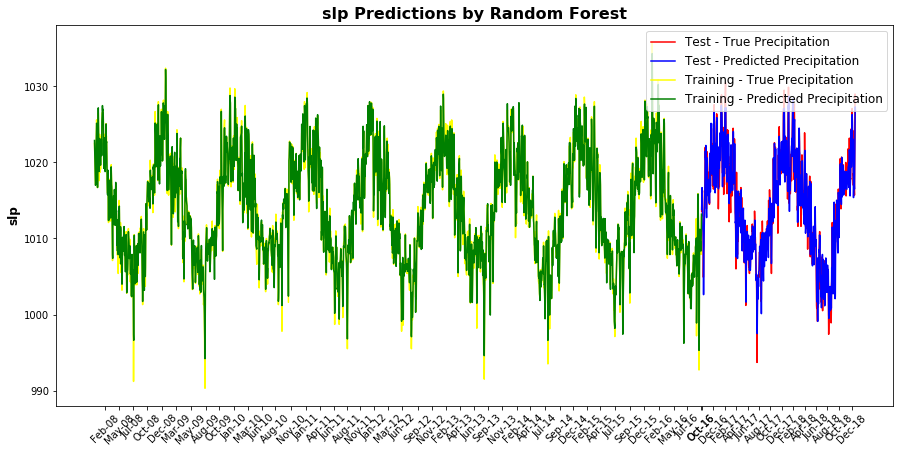

In [231]:
for weather in DF:
    x_train, y_train, x_test, y_test, x_val, y_val,_ = data_set[weather]
    Y_train = RF[weather].predict(x_train)
    Y_test = RF[weather].predict(x_test)
    # sort the indcies
    order = y_train.index.argsort()
    sorted_yt = y_train[order]
    sorted_yp = Y_train[order]
    x_axis = [DF[weather].iloc[ntrain:].index, sorted_yt.index]
    y_axis = [[y_test, Y_test], [sorted_yt, sorted_yp]]
    
    plt.figure(figsize=(15,7))
    p1, = plt.plot(x_axis[0], y_axis[0][0], color[weather][0][0] ) # plot actual temperature
    p2, = plt.plot(x_axis[0], y_axis[0][1], color[weather][0][1]) # plot predicted temperature
    p3, = plt.plot(x_axis[1], y_axis[1][0], color[weather][1][0] ) # plot actual temperature
    p4, = plt.plot(x_axis[1], y_axis[1][1], color[weather][1][1] ) # plot actual temperature
        
    combined_x = [i for j in range(2) for i in x_axis[j]]
    plt.xticks(combined_x[::x_space[1]], rotation = 45) # set xticks to monthly
    myFmt = mdates.DateFormatter("%b-%y") # This shows day-month-year. Switch to month-year or annually
    plt.gca().xaxis.set_major_formatter(myFmt)

    plt.title(weather+" Predictions by Random Forest",fontsize = 16,weight = "bold")
    plt.ylabel(weather, fontsize = 12,weight = "bold")
    plt.legend([p1,p2,p3,p4],['Test - True Precipitation','Test - Predicted Precipitation','Training - True Precipitation','Training - Predicted Precipitation'], fontsize = 12, loc = 1) 



## 3. Plot 

In [40]:
color = {"temp":[["lightcoral", "deepskyblue"], ["skyblue","slateblue"]],
         "wdsp":[["lightsteelblue", "violet"], ["darkseagreen", "sandybrown"]],
         "prcp":[["gray", "goldenrod"], ["rosybrown", "cadetblue"]],
         "slp":[["r","blue"],["yellow","green"]]}
x_space = [30, 60]
title = ["Test Set", "Training Set"]

In [ ]:
def Plot(x_axis, y_axis, color, x_space,weather):
    fig_num = len(x_axis)
    for fig in range(fig_num):
        plt.figure(figsize=(15,7))
        plt.plot(x_axis[fig], y_axis[fig][0], color[fig][0] ) # plot actual temperature
        plt.plot(x_axis[fig], y_axis[fig][1], color[fig][1]) # plot predicted temperature
        
        plt.xticks(x_axis[fig][::x_space[fig]], rotation = 45) # set xticks to monthly
        myFmt = mdates.DateFormatter('%b-%y') # This shows day-month-year. Switch to month-year or annually
        plt.gca().xaxis.set_major_formatter(myFmt)
        
        plt.title(title[fig] + ": "+weather+" Predictions",fontsize = 16,weight = "bold")
        plt.ylabel(weather, fontsize = 12, weight = "bold")
        plt.legend(('True '+weather,'Predicted '+weather), fontsize = 12, loc = 1)  
    plt.show()

In [65]:
Best_model

{'prcp': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False),
 'slp': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False),
 'temp': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False),
 'wdsp': SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
   kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)}

temp
0.9909850820625355
0.9461554544751645
0.9468676338939929
	RMSE of 1.16
	MAE of 0.75 

wdsp
0.8892125496066867
0.39432750123640575
0.4121395155288934
	RMSE of 0.60
	MAE of 0.57 

prcp
0.8462115906743308
0.16736209301172567
0.10663454091292758
	RMSE of 0.02
	MAE of 0.06 

slp
0.9890338036218188
0.9304714578642005
0.9361788579080432
	RMSE of 0.51
	MAE of 0.52 



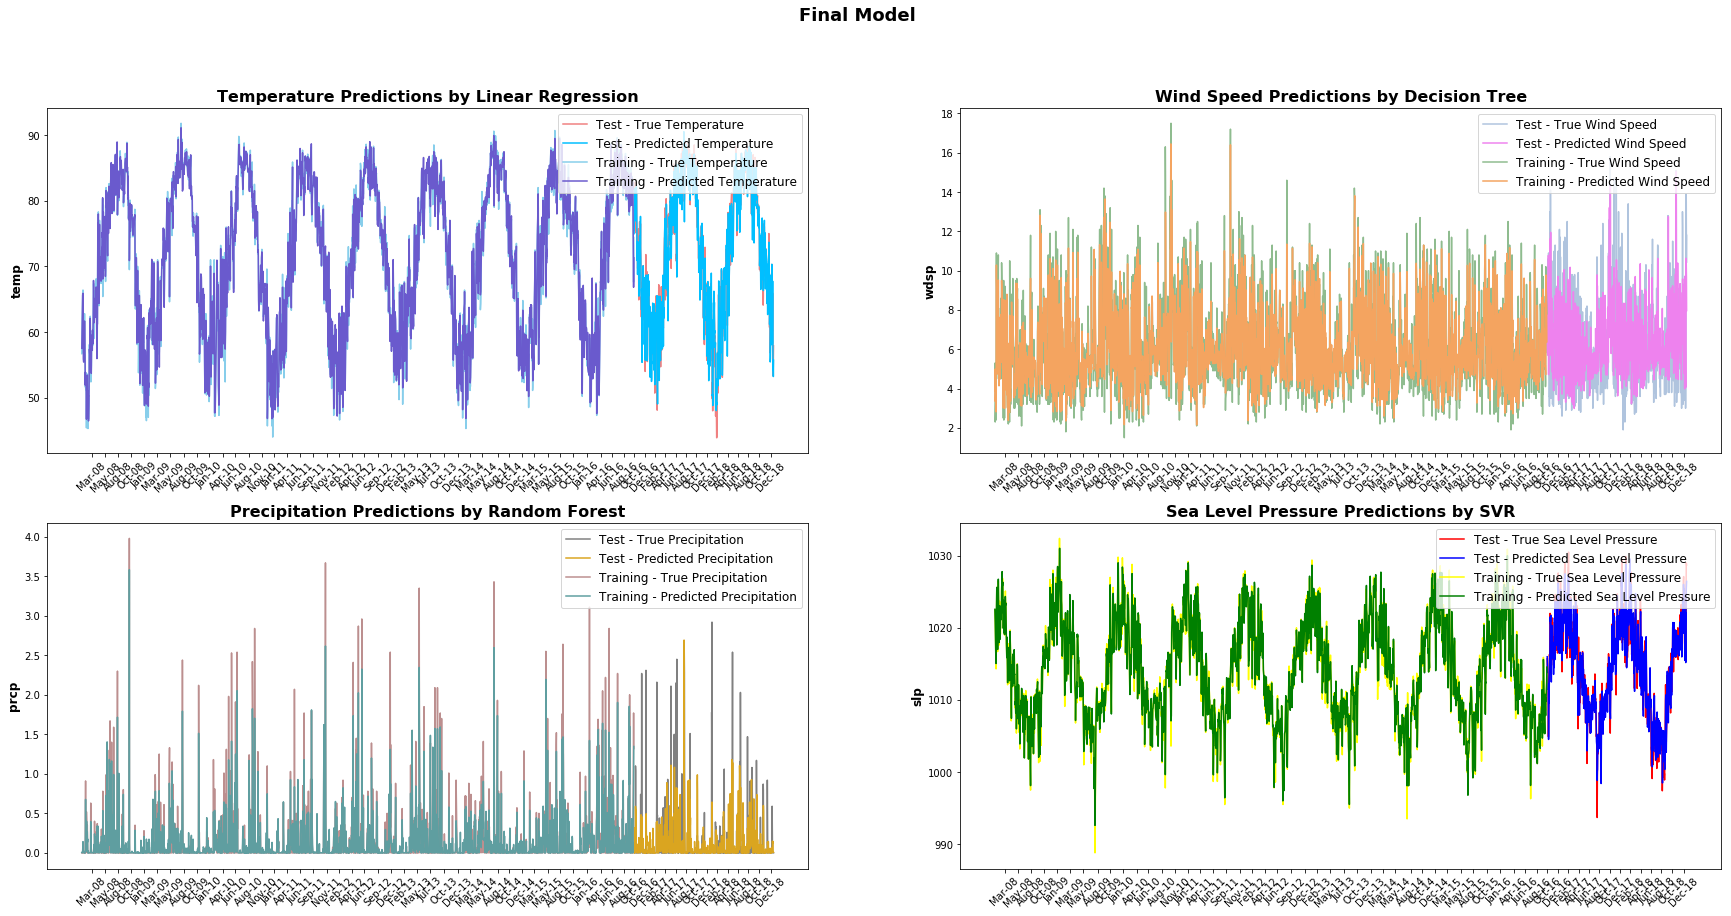

In [83]:
from sklearn import neighbors
from sklearn.decomposition import PCA

plt.figure(figsize=(30,14))
plt.suptitle("Final Model", fontsize = 18, weight = "bold")
#plt.suptitle("Improvement RF Model - Prediction Plot", fontsize = 18, weight = "bold")
gs = GridSpec(10, 20)
n = 0
col = 0

mod = [rf[1],
       rf[2],
       rf[3],
       rf[4]]


nm = ["Linear Regression", "Decision Tree", "Random Forest", "SVR"]
#mod = [RF["temp"],RF["wdsp"],RF["prcp"],RF["slp"]]
title = {"temp":"Temperature","wdsp":"Wind Speed","prcp":"Precipitation","slp":"Sea Level Pressure"}
for weather in DF:
    print(weather)
    m = RF[weather]
    #m = mod[n]
    x_train, y_train, x_test, y_test, x_val, y_val,_ = data_set[weather]
    pca = PCA(10, whiten = True)
    for x in [x_train, x_test, x_val]:
        avg = pca.fit_transform(x)
        x = np.dot(avg,avg.T).dot(x)
    m.fit(x_train, y_train)
    Y_train = m.predict(x_train)
    Y_test = m.predict(x_test)
    print(m.score(x_train, y_train))
    print(m.score(x_val, y_val))
    print(m.score(x_test, y_test))
    print("\tRMSE of {:.4}".format(str(mean_squared_error(y_train, Y_train))))
    print("\tMAE of {:.4} \n".format(str(mean_absolute_error(y_train, Y_train))))
    # sort the indcies
    order = y_train.index.argsort()
    sorted_yt = y_train[order]
    sorted_yp = Y_train[order]
    x_axis = [DF[weather].iloc[ntrain:].index, sorted_yt.index]
    y_axis = [[y_test, Y_test], [sorted_yt, sorted_yp]]
    #Plot(x_axis, y_axis, color[weather], x_space, weather)
    
    plt.subplot(221+n)
    col += 10
    
    p1, = plt.plot(x_axis[0], y_axis[0][0], color[weather][0][0] ) # plot actual temperature
    p2, = plt.plot(x_axis[0], y_axis[0][1], color[weather][0][1]) # plot predicted temperature
    p3, = plt.plot(x_axis[1], y_axis[1][0], color[weather][1][0] ) # plot actual temperature
    p4, = plt.plot(x_axis[1], y_axis[1][1], color[weather][1][1] ) # plot actual temperature
        
    combined_x = [i for j in range(2) for i in x_axis[j]]
    plt.xticks(combined_x[::x_space[1]], rotation = 45) # set xticks to monthly
    myFmt = mdates.DateFormatter("%b-%y") # This shows day-month-year. Switch to month-year or annually
    plt.gca().xaxis.set_major_formatter(myFmt)

    plt.title(title[weather]+" Predictions by "+ nm[n],fontsize = 16,weight = "bold")
    plt.ylabel(weather, fontsize = 12,weight = "bold")
    plt.legend([p1,p2,p3,p4],['Test - True '+title[weather],'Test - Predicted '+title[weather],
                              'Training - True '+title[weather],'Training - Predicted '+title[weather]], 
               fontsize = 12, loc = 1) 
    n += 1


In [56]:
bm_name = ["Linear Regression", "LassoLarsCV", "Gradient Boost", "SVR"]
rf[3]

DecisionTreeRegressor(criterion='mse', max_depth=20, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=424247572, splitter='best')

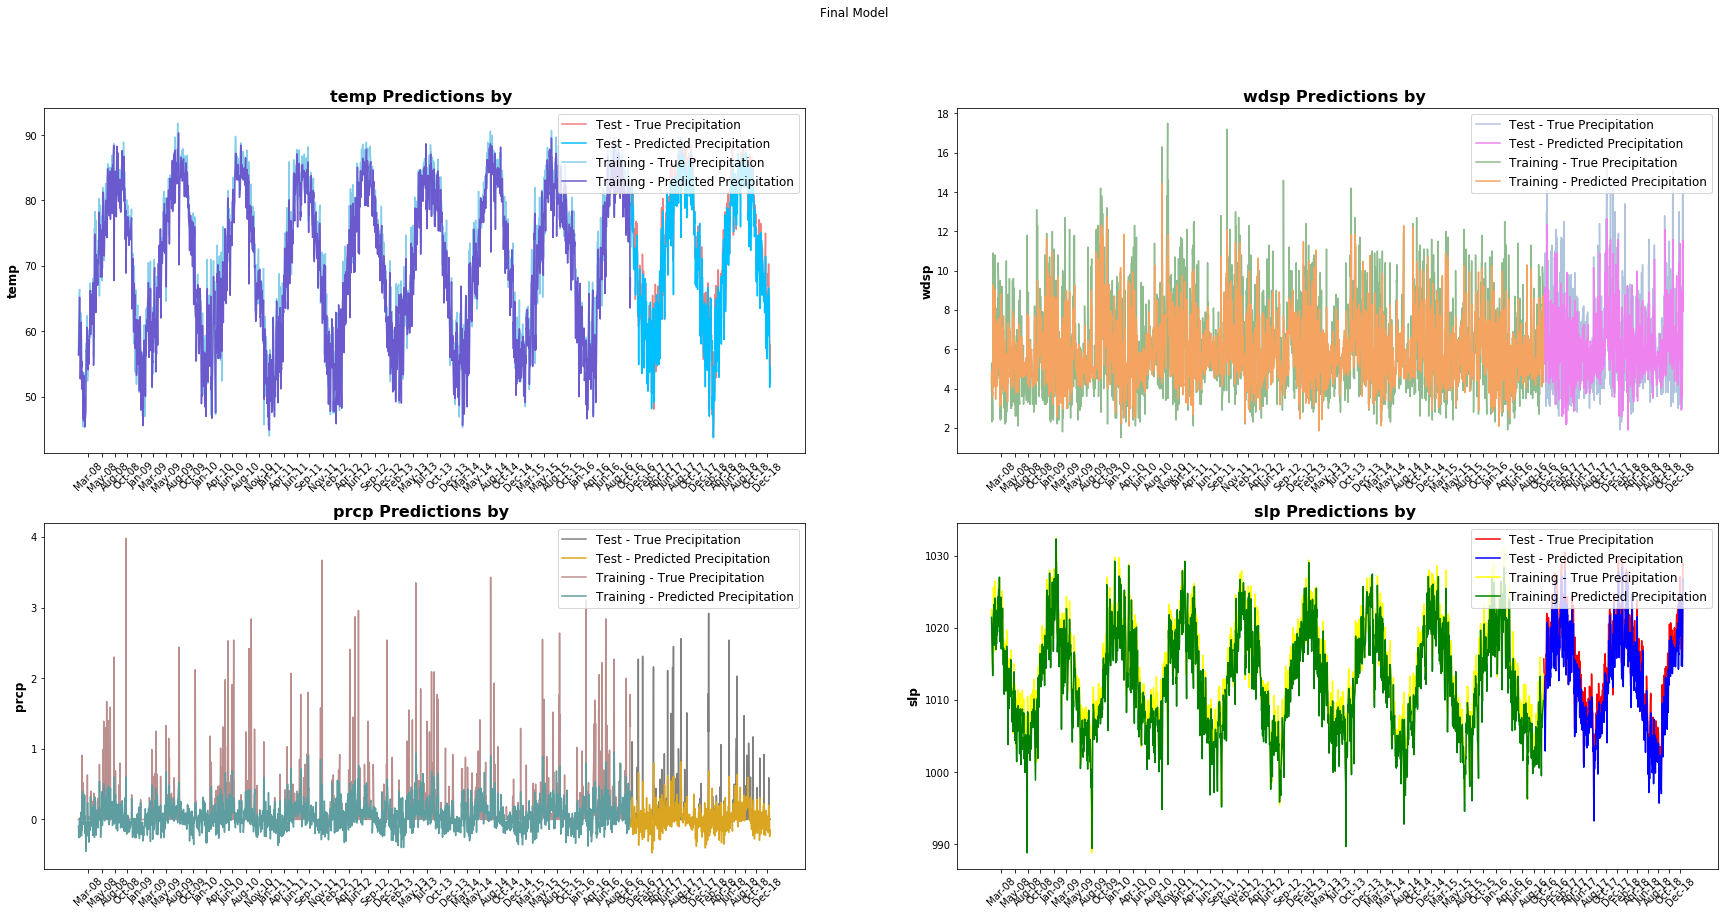

In [77]:
plt.figure(figsize=(30,14))
plt.suptitle("Final Model")
n = 221
for weather in DF:
    x_train, y_train, x_test, y_test, x_val, y_val,_ = data_set[weather]
    Y_train = Best_model[weather].predict(x_train)
    Y_test = Best_model[weather].predict(x_test)
    # sort the indcies
    order = y_train.index.argsort()
    sorted_yt = y_train[order]
    sorted_yp = Y_train[order]
    x_axis = [DF[weather].iloc[ntrain:].index, sorted_yt.index]
    y_axis = [[y_test, Y_test], [sorted_yt, sorted_yp]]
    #Plot(x_axis, y_axis, color[weather], x_space, weather)
    
    plt.subplot(n)
    n += 1
    p1, = plt.plot(x_axis[0], y_axis[0][0], color[weather][0][0] ) # plot actual temperature
    p2, = plt.plot(x_axis[0], y_axis[0][1], color[weather][0][1]) # plot predicted temperature
    p3, = plt.plot(x_axis[1], y_axis[1][0], color[weather][1][0] ) # plot actual temperature
    p4, = plt.plot(x_axis[1], y_axis[1][1], color[weather][1][1] ) # plot actual temperature
        
    combined_x = [i for j in range(2) for i in x_axis[j]]
    plt.xticks(combined_x[::x_space[1]], rotation = 45) # set xticks to monthly
    myFmt = mdates.DateFormatter("%b-%y") # This shows day-month-year. Switch to month-year or annually
    plt.gca().xaxis.set_major_formatter(myFmt)

    plt.title(weather+" Predictions by ",fontsize = 16,weight = "bold")
    plt.ylabel(weather, fontsize = 12,weight = "bold")
    plt.legend([p1,p2,p3,p4],['Test - True Precipitation','Test - Predicted Precipitation','Training - True Precipitation','Training - Predicted Precipitation'], fontsize = 12, loc = 1) 



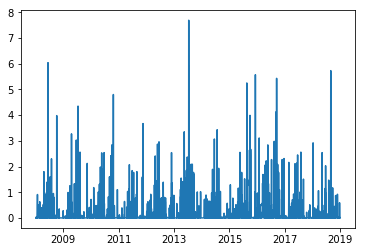

In [268]:
plt.plot(data_set['prcp'][-1])